In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import f_oneway
import ast

import sklearn

import importlib

import Projet4_utils as utils
importlib.reload(utils)

<module 'Projet4_utils' from 'e:\\Git\\OpenClassrooms_project4\\Projet4_utils.py'>

# Read data and concatenate dataframes
#### The data from 2015 and 2016 are given in 2 different files. We first need to concatenate it into one single dataframe. To do that, we need to check the features available in each file, for instance those corresponding to the same measurement but with different names

In [2]:
PATH = "./Data"

df2015 = pd.read_csv(os.path.join(PATH, "2015-building-energy-benchmarking.csv"), low_memory = False)
df2016 = pd.read_csv(os.path.join(PATH, "2016-building-energy-benchmarking.csv"), low_memory = False)

In [3]:
print(df2015.shape)
print(df2016.shape)

(3340, 47)
(3376, 46)


In [4]:
print("Variables in 2015 but not in 2016 :")
utils.diff_lists(df2015.columns.tolist(), df2016.columns.tolist())[0]

Variables in 2015 but not in 2016 :


['GHGEmissionsIntensity(kgCO2e/ft2)',
 'SPD Beats',
 'GHGEmissions(MetricTonsCO2e)',
 '2010 Census Tracts',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'City Council Districts',
 'OtherFuelUse(kBtu)',
 'Location',
 'Comment',
 'Zip Codes']

In [5]:
print("Variables in 2016 but not in 2015 :")
utils.diff_lists(df2015.columns.tolist(), df2016.columns.tolist())[1]

Variables in 2016 but not in 2015 :


['Comments',
 'State',
 'Address',
 'Latitude',
 'TotalGHGEmissions',
 'ZipCode',
 'City',
 'GHGEmissionsIntensity',
 'Longitude']

#### The location feature in the 2015 df regroups sevral information that are in separate features in the 2016 df. We separate them in order to match the 2016 format

In [6]:
print(df2015['Location'].head())

0    {'latitude': '47.61219025', 'longitude': '-122...
1    {'latitude': '47.61310583', 'longitude': '-122...
2    {'latitude': '47.61334897', 'longitude': '-122...
3    {'latitude': '47.61421585', 'longitude': '-122...
4    {'latitude': '47.6137544', 'longitude': '-122....
Name: Location, dtype: object


In [7]:
df2015['Location'] = [ast.literal_eval(str(item)) for index, item in df2015.Location.iteritems()]
df2015 = pd.concat([df2015.drop(['Location'], axis=1), df2015['Location'].apply(pd.Series)], axis=1)

df2015['human_address'] = [ast.literal_eval(str(item)) for index, item in df2015.human_address.iteritems()]
df2015 = pd.concat([df2015.drop(['human_address'], axis=1), df2015['human_address'].apply(pd.Series)], axis=1)
df2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,latitude,longitude,address,city,state,zip
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1,...,14.0,NaN,31.0,18081,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,WA,98101
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1,...,14.0,NaN,31.0,18081,47.61310583,-122.33335756,724 PINE ST,SEATTLE,WA,98101
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1,...,56.0,NaN,31.0,18081,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,WA,98101
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,7,DOWNTOWN,1926,1,...,56.0,NaN,31.0,18081,47.61421585,-122.33660889,620 STEWART ST,SEATTLE,WA,98101
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,7,DOWNTOWN,1980,1,...,56.0,NaN,31.0,19576,47.6137544,-122.3409238,401 LENORA ST,SEATTLE,WA,98121


#### We rename here the features that are obviously the same but with different names

In [8]:
df2015 = df2015.rename(columns={"latitude":"Latitude", 
                                  "longitude":"Longitude",
                                  "address":"Address", 
                                  "city":"City", 
                                  "state":"State", 
                                  "zip":"ZipCode",
                                  "GHGEmissions(MetricTonsCO2e)":"TotalGHGEmissions",
                                  "GHGEmissionsIntensity(kgCO2e/ft2)":"GHGEmissionsIntensity",
                                  "Comment":"Comments"})

In [9]:
print("Variables in 2015 but not in 2016 :")
utils.diff_lists(df2015.columns.tolist(), df2016.columns.tolist())[0]

Variables in 2015 but not in 2016 :


['SPD Beats',
 '2010 Census Tracts',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'City Council Districts',
 'OtherFuelUse(kBtu)',
 'Zip Codes']

#### The other features in the 2015 df but not in 2016 are irrelevant in our study -> remove the columns

In [10]:
df2015.drop(utils.diff_lists(df2015.columns.tolist(), df2016.columns.tolist())[0], axis = 1, inplace = True)

In [11]:
print("Variables in 2015 but not in 2016 :")
utils.diff_lists(df2015.columns.tolist(), df2016.columns.tolist())[0]

Variables in 2015 but not in 2016 :


[]

#### Convert values to float type

In [12]:
df2015[['Latitude','Longitude', 'ZipCode']] = df2015[['Latitude','Longitude', 'ZipCode']].astype('float64')

#### Concatenate dataframes

In [13]:
df = pd.concat([df2015, df2016], axis=0).sort_values('DataYear')

In [14]:
df.shape

(6716, 46)

In [15]:
df.isnull().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
TaxParcelIdentificationNumber         2
CouncilDistrictCode                   0
Neighborhood                          0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        8
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes           136
LargestPropertyUseType              156
LargestPropertyUseTypeGFA           156
SecondLargestPropertyUseType       3478
SecondLargestPropertyUseTypeGFA    3478
ThirdLargestPropertyUseType        5560
ThirdLargestPropertyUseTypeGFA     5560
YearsENERGYSTARCertified           6487
ENERGYSTARScore                    1623
SiteEUI(kBtu/sf)                     17
SiteEUIWN(kBtu/sf)                   16


In [16]:
df.to_csv(r'E:/OpenClassrooms/Projet4/building_energy_benchmark_2015-2016.csv', index = False)

# Cleaning

In [17]:
df = pd.read_csv(os.path.join("E:/OpenClassrooms/Projet4", "building_energy_benchmark_2015-2016.csv"), low_memory = False)

In [18]:
df.columns.tolist()

['OSEBuildingID',
 'DataYear',
 'BuildingType',
 'PrimaryPropertyType',
 'PropertyName',
 'TaxParcelIdentificationNumber',
 'CouncilDistrictCode',
 'Neighborhood',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'YearsENERGYSTARCertified',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'DefaultData',
 'Comments',
 'ComplianceStatus',
 'Outlier',
 'Latitude',
 'Longitude',
 'Address',
 'City',
 'State',
 'ZipCode']

#### Delete irrelevant and redundant variables

In [19]:
df.drop(['State', 'ZipCode', 'Comments', 'City'], axis = 1, inplace = True)  #irrelevant variables

In [20]:
df.drop(['Electricity(kBtu)', 'NaturalGas(therms)'], axis = 1, inplace = True)  #redundant variables
df.drop(['Neighborhood'], axis = 1, inplace = True)
df.drop(['Outlier', 'ComplianceStatus', 'DefaultData'], axis = 1, inplace = True)   #Too much missing data + not really useful

In [21]:
list_WN = [i for i in df.columns if 'WN' in i]  # delete weather normalized variables
df.drop(list_WN, axis = 1, inplace = True)

#### Delete residential buildings

In [22]:
df['BuildingType'].unique()

array(['NonResidential', 'Multifamily LR (1-4)', 'Multifamily MR (5-9)',
       'Multifamily HR (10+)', 'SPS-District K-12', 'Nonresidential COS',
       'Campus', 'Nonresidential WA'], dtype=object)

In [23]:
list_residential = [i for i in df['BuildingType'].unique().tolist() if 'Multifamily' in i]
print(list_residential)
#print(df.loc[df['BuildingType']=='Multifamily HR (10+)'])

['Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'Multifamily HR (10+)']


In [24]:
df = df.loc[~df['BuildingType'].isin(list_residential)]

In [25]:
df.shape

(3318, 33)

In [26]:
df['BuildingType'].unique()

array(['NonResidential', 'SPS-District K-12', 'Nonresidential COS',
       'Campus', 'Nonresidential WA'], dtype=object)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3318 entries, 0 to 6715
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3318 non-null   int64  
 1   DataYear                         3318 non-null   int64  
 2   BuildingType                     3318 non-null   object 
 3   PrimaryPropertyType              3318 non-null   object 
 4   PropertyName                     3318 non-null   object 
 5   TaxParcelIdentificationNumber    3317 non-null   object 
 6   CouncilDistrictCode              3318 non-null   int64  
 7   YearBuilt                        3318 non-null   int64  
 8   NumberofBuildings                3316 non-null   float64
 9   NumberofFloors                   3310 non-null   float64
 10  PropertyGFATotal                 3318 non-null   int64  
 11  PropertyGFAParking               3318 non-null   int64  
 12  PropertyGFABuilding(

#### Fill missing data (number of floors and buildings). If missing, we assume there is only 1 floor/building

In [28]:
print(df['NumberofFloors'].isnull().sum())

8


In [29]:
df.loc[df['NumberofFloors'].isnull(),'NumberofFloors'] = 1
df.loc[df['NumberofBuildings'].isnull(),'NumberofBuildings'] = 1

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3318 entries, 0 to 6715
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3318 non-null   int64  
 1   DataYear                         3318 non-null   int64  
 2   BuildingType                     3318 non-null   object 
 3   PrimaryPropertyType              3318 non-null   object 
 4   PropertyName                     3318 non-null   object 
 5   TaxParcelIdentificationNumber    3317 non-null   object 
 6   CouncilDistrictCode              3318 non-null   int64  
 7   YearBuilt                        3318 non-null   int64  
 8   NumberofBuildings                3318 non-null   float64
 9   NumberofFloors                   3318 non-null   float64
 10  PropertyGFATotal                 3318 non-null   int64  
 11  PropertyGFAParking               3318 non-null   int64  
 12  PropertyGFABuilding(

### Outliers

#### Electricity Use
#### 1 building with <0 energy use, corresponding to a self sustainable building and producing electricity, not representative of our study -> delete row

In [31]:
df['Electricity(kWh)'].describe()

count    3.309000e+03
mean     1.651947e+06
std      5.102228e+06
min     -3.382680e+04
25%      2.120948e+05
50%      4.758666e+05
75%      1.429920e+06
max      1.925775e+08
Name: Electricity(kWh), dtype: float64

In [32]:
df.loc[df['Electricity(kWh)']<0, :]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,...,SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address
4512,49784,2016,NonResidential,Small- and Mid-Sized Office,Bullitt Center,7234600195,3,2013,1.0,6.0,...,2.0,342726.0938,0.0,-33826.80078,0.0,-0.8,-0.02,47.61432,-122.31257,1501 E. Madison St.


In [33]:
ind=df.loc[df['Electricity(kWh)']<0, :].index[0]
#print(ind)
df.drop(ind, axis=0, inplace=True)

In [34]:
df.loc[df['Electricity(kWh)']<0, :]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,...,SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address


#### 1 building with extremely high energy use -> university of Washington, 111 buildings, not representative of our study -> delete row

In [35]:
df.loc[df['Electricity(kWh)'] == max(df['Electricity(kWh)']), :]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,...,SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address
4422,49967,2016,Campus,University,University of Washington - Seattle Campus,1625049001,4,1900,111.0,0.0,...,246.600006,873923712.0,84985240.0,192577488.0,0.0,11140.56,1.2,47.65644,-122.31041,NE 45th St & Brooklyn Ave


In [36]:
ind = df.loc[df['Electricity(kWh)'] == max(df['Electricity(kWh)']), :].index[0]
print(ind)
df.drop(ind, axis=0, inplace=True)

4422


In [37]:
df.loc[df['Electricity(kWh)'] == max(df['Electricity(kWh)']), :]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,...,SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address
1694,753,2015,NonResidential,Other,THE WESTIN BUILDING,659000950,7,1981,1.0,33.0,...,2082.3,284867168.0,0.0,83445048.0,152639.0,1992.96,1.79,47.614353,-122.33886,2001 6TH AVE


#### Negative GFA -> only 3 buildings -> delete rows (We do not lose too much data, and it is safer than assume or imput values)

In [38]:
df.loc[df['PropertyGFABuilding(s)']<=0, ['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)']]

,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s)
1101,33648,84198,-50550
1179,54015,97325,-43310


In [39]:
ind = df.loc[df['PropertyGFABuilding(s)']<=0, ['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)']].index
#print(df.iloc[df.index[ind]])
df.drop(ind, axis=0, inplace = True)

In [40]:
df.loc[df['PropertyGFABuilding(s)']<=0, ['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)']]

,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s)


In [41]:
df.loc[df['PropertyGFAParking']<0, ['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)']]

,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s)
1176,68452,-2,68454


In [42]:
ind = df.loc[df['PropertyGFAParking']<0].index
print(ind)
df.drop(ind, axis=0, inplace=True)

Int64Index([1176], dtype='int64')


In [43]:
df.loc[df['PropertyGFAParking']<0, ['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)']]

,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s)


#### Save dataframe

In [44]:
df.to_csv(r'E:/OpenClassrooms/Projet4/building_energy_benchmark_2015-2016_clean.csv', index = False)

# Exploration

In [45]:
df = pd.read_csv(os.path.join("E:/OpenClassrooms/Projet4", "building_energy_benchmark_2015-2016_clean.csv"), low_memory = False)

In [46]:
df.columns.tolist()

['OSEBuildingID',
 'DataYear',
 'BuildingType',
 'PrimaryPropertyType',
 'PropertyName',
 'TaxParcelIdentificationNumber',
 'CouncilDistrictCode',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'YearsENERGYSTARCertified',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'NaturalGas(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'Latitude',
 'Longitude',
 'Address']

In [47]:
# Create a list of all the continuous variables
list_quantitative = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
                    'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
                    'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']

#### Distributions of the different continuous variables. We notice that most are very asymetric and will require a transformation to  be more symetric and close to a normal distribution. Additionnaly, they are distributed in very different value ranges, therefore they will also need to be scaled, in order for them to be all in (approximately) the same range

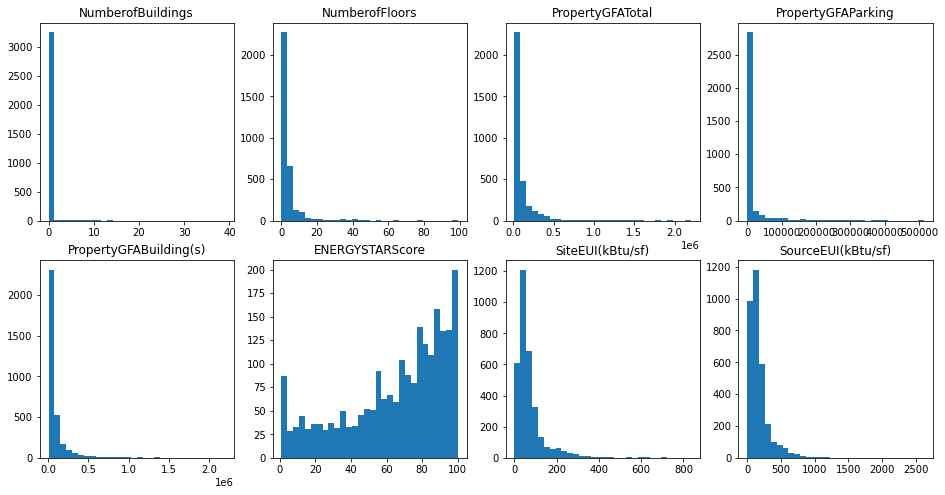

In [58]:
list_plot_distri = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
                    'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)']
fig = plt.figure(figsize=(16,8))
for i in range(len(list_plot_distri)):
    ax = fig.add_subplot(2,4,(i+1))
    h = ax.hist(df[list_plot_distri[i]], 30)
    ax.set_title(list_plot_distri[i])
    
plt.show()

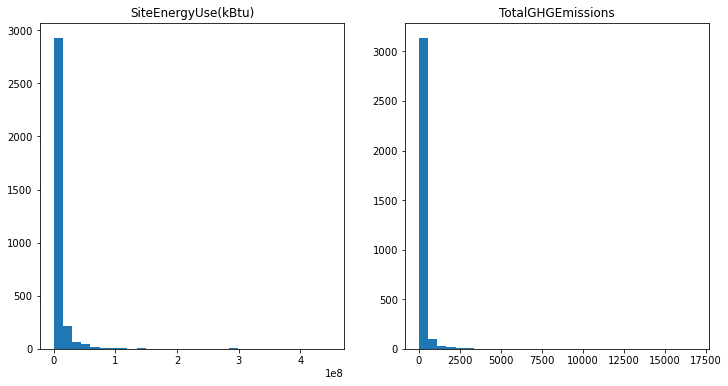

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.hist(df['SiteEnergyUse(kBtu)'], 30)
ax1.set_title('SiteEnergyUse(kBtu)')

ax2.hist(df['TotalGHGEmissions'], 30)
ax2.set_title('TotalGHGEmissions')

plt.show()

<AxesSubplot:ylabel='BuildingType'>

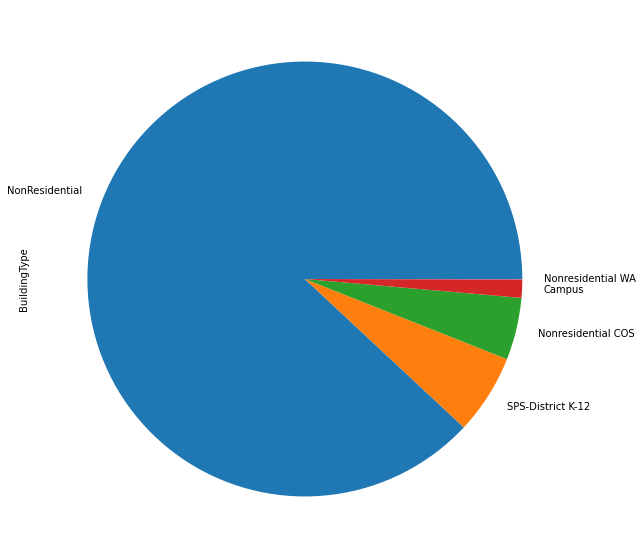

In [54]:
# Distribution of the building types
df['BuildingType'].value_counts(normalize = False).plot(kind='pie', figsize = (10,10))

<AxesSubplot:>

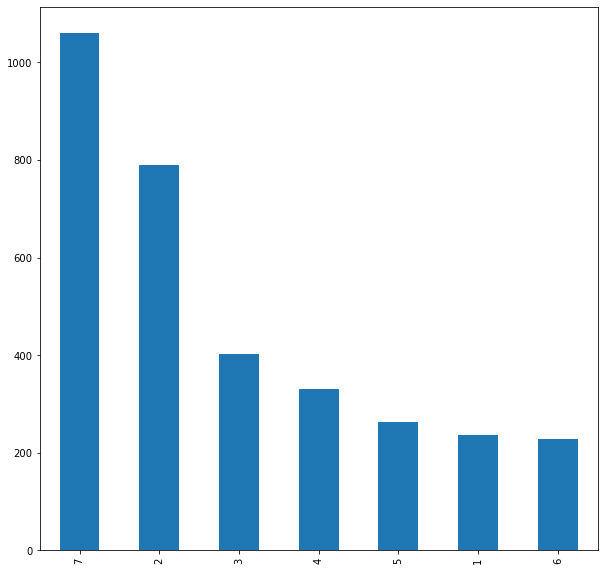

In [55]:
# Distribution of the mealsured buildings in the different neighborhoods
df['CouncilDistrictCode'].value_counts(normalize = False).plot(kind='bar', figsize = (10,10))

Text(0.5, 1.0, 'Distribution of the year of the building construction or last renovation')

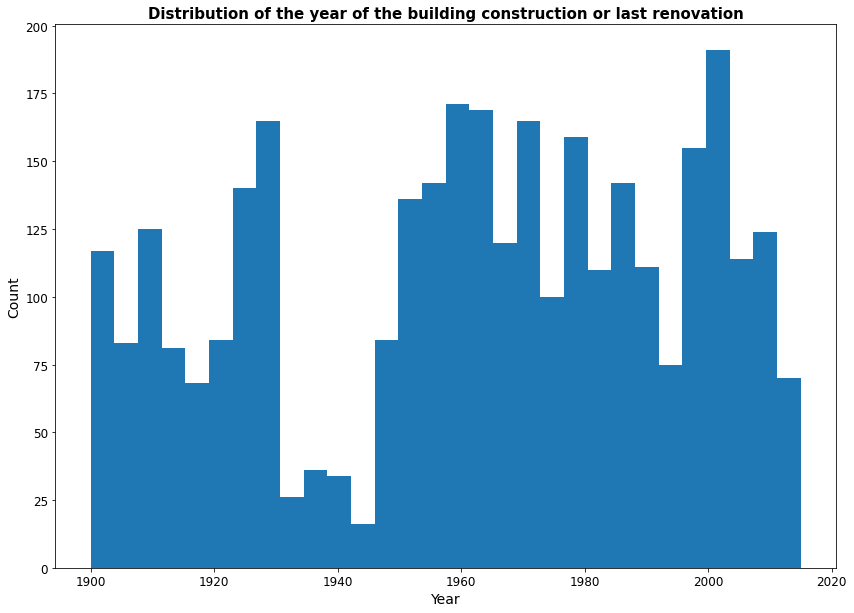

In [56]:
# Distribution of the building years
# We notice a tri-modal distribution, approximately a superposition of 3 normal distribution

plt.figure(figsize = (14,10))
plt.hist(df['YearBuilt'], 30)

plt.xlabel('Year', fontsize = 14)
plt.xticks(fontsize = 12)
plt.ylabel('Count', fontsize = 14)
plt.yticks(fontsize = 12)
plt.title('Distribution of the year of the building construction or last renovation', fontsize= 15, fontweight = 'bold')

### Link between energy use/GHG emission and building type. Campuses seem to use more energy and emit more GHG than the other building types


<AxesSubplot:title={'center':'SiteEnergyUse(kBtu)'}, xlabel='BuildingType'>

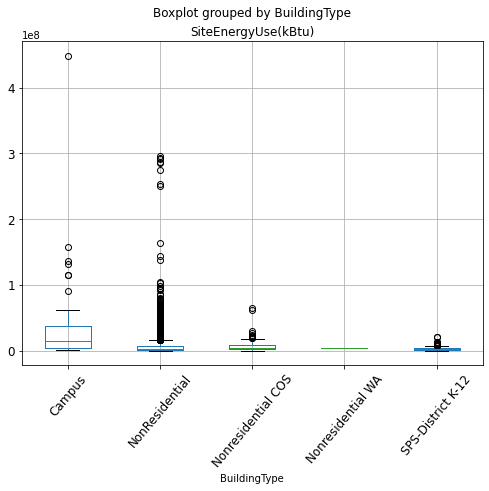

In [66]:
df.boxplot(column=['SiteEnergyUse(kBtu)'], by='BuildingType', figsize = (8,6), fontsize = 12, vert = True, rot = 50)

<AxesSubplot:title={'center':'TotalGHGEmissions'}, xlabel='BuildingType'>

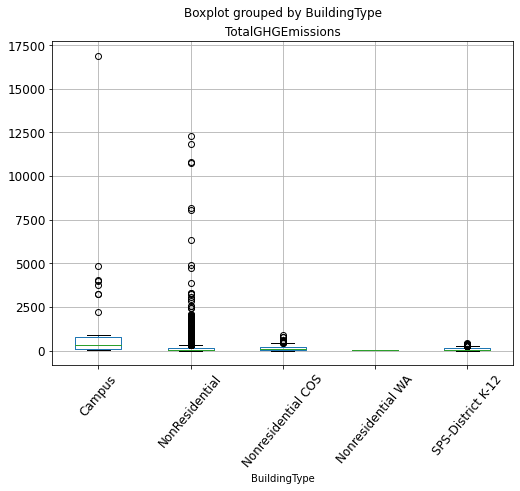

In [68]:
df.boxplot(column=['TotalGHGEmissions'], by='BuildingType', figsize = (8,6), fontsize = 12, vert = True, rot=50)

### Correlation between the continuous variables heatmap

<AxesSubplot:>

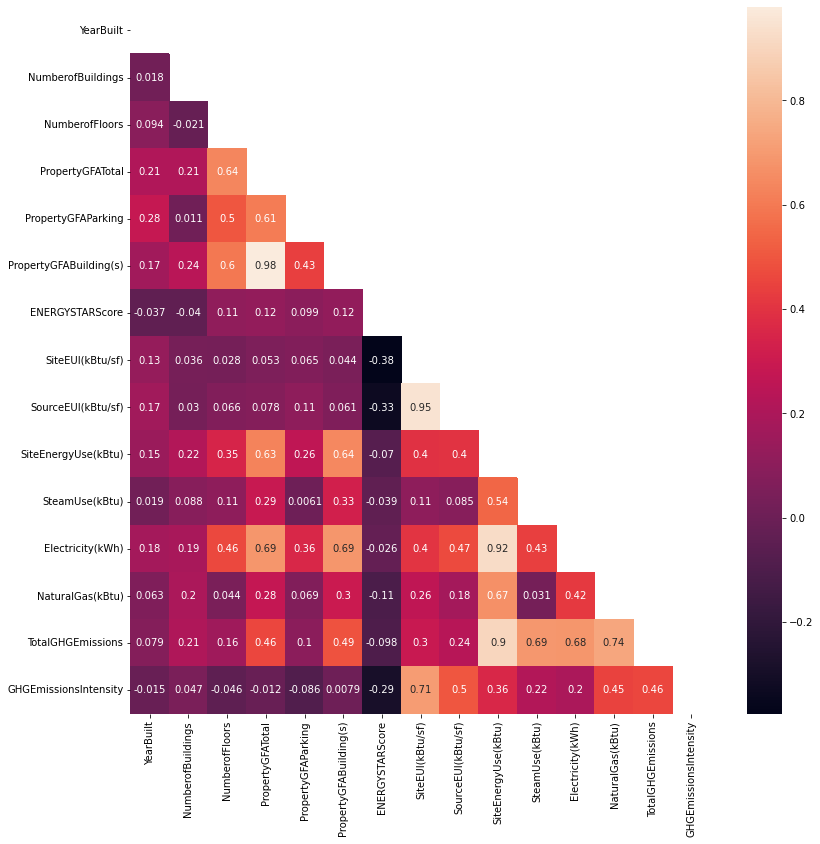

In [59]:
plt.figure(figsize=(13,13))
corr = df[list_quantitative].corr() 
mask = np.triu(corr)
sns.heatmap(corr, mask=mask, annot=True)

In [60]:
df.to_csv(r'E:/OpenClassrooms/Projet4/building_energy_benchmark_2015-2016_explored.csv', index = False)

# Feature engineering
#### We need to prepare the dataframe for the tranformations and the ML algorithms

In [61]:
df = pd.read_csv(os.path.join("E:/OpenClassrooms/Projet4", "building_energy_benchmark_2015-2016_explored.csv"), low_memory = False)

### Transform largest property use to GFA
#### The property uses are given in strings, we need to convert to numerical values. Rather than just attributing a number to each use, we can put the GFA dedicated to each use for each building.

In [62]:
LargestType = df['LargestPropertyUseType'].unique().tolist()
SecondaryType = df['SecondLargestPropertyUseType'].unique().tolist()
TertiaryType = df['ThirdLargestPropertyUseType'].unique().tolist()

all_type = set(LargestType + SecondaryType + TertiaryType)

In [63]:
all_type.remove(np.nan)
all_type

{'Adult Education',
 'Automobile Dealership',
 'Bank Branch',
 'Bar/Nightclub',
 'College/University',
 'Convenience Store without Gas Station',
 'Convention Center',
 'Courthouse',
 'Data Center',
 'Distribution Center',
 'Enclosed Mall',
 'Fast Food Restaurant',
 'Financial Office',
 'Fire Station',
 'Fitness Center/Health Club/Gym',
 'Food Sales',
 'Food Service',
 'Hospital (General Medical & Surgical)',
 'Hotel',
 'K-12 School',
 'Laboratory',
 'Library',
 'Lifestyle Center',
 'Manufacturing/Industrial Plant',
 'Medical Office',
 'Movie Theater',
 'Multifamily Housing',
 'Museum',
 'Non-Refrigerated Warehouse',
 'Office',
 'Other',
 'Other - Education',
 'Other - Entertainment/Public Assembly',
 'Other - Lodging/Residential',
 'Other - Mall',
 'Other - Public Services',
 'Other - Recreation',
 'Other - Restaurant/Bar',
 'Other - Services',
 'Other - Technology/Science',
 'Other - Utility',
 'Other/Specialty Hospital',
 'Outpatient Rehabilitation/Physical Therapy',
 'Parking',
 'Pe

#### We first create a df filled with zeroes, with colupns corresponding to the different property uses

In [64]:
d = pd.DataFrame(0, index=df.index, columns = all_type)
d.head()

,Other - Public Services,Residence Hall/Dormitory,Adult Education,Fast Food Restaurant,Data Center,Other - Services,Library,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Bar/Nightclub,Self-Storage Facility,...,Museum,Outpatient Rehabilitation/Physical Therapy,Bank Branch,Food Service,Other - Entertainment/Public Assembly,Other - Technology/Science,Courthouse,Other - Education,Laboratory,Fitness Center/Health Club/Gym
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### For each building, we retrieve the different property uses and their dedicated GFA. We then fill the new df with the GFAs (gives a sparse dataframe)

In [65]:
for i in df.index:
    LargestType = df.loc[i, 'LargestPropertyUseType']
    LargestGFA = df.loc[i, 'LargestPropertyUseTypeGFA']
    
    SecondLargestType = df.loc[i, 'SecondLargestPropertyUseType']
    SecondLargestGFA = df.loc[i, 'SecondLargestPropertyUseTypeGFA']
    
    ThirdLargestType = df.loc[i, 'ThirdLargestPropertyUseType']
    ThirdLargestGFA = df.loc[i, 'ThirdLargestPropertyUseTypeGFA']
    
    d.loc[i, LargestType] = LargestGFA
    d.loc[i, SecondLargestType] = SecondLargestGFA
    d.loc[i, ThirdLargestType] = ThirdLargestGFA

In [66]:
d = d.drop(np.nan, axis = 1)
d.fillna(0, inplace = True)

In [67]:
# Check 
df.loc[1, ['LargestPropertyUseType',
           'LargestPropertyUseTypeGFA',
           'SecondLargestPropertyUseType',
           'SecondLargestPropertyUseTypeGFA',
           'ThirdLargestPropertyUseType',
           'ThirdLargestPropertyUseTypeGFA'
          ]
      ]

LargestPropertyUseType             Self-Storage Facility
LargestPropertyUseTypeGFA                          21018
SecondLargestPropertyUseType                     Parking
SecondLargestPropertyUseTypeGFA                     3230
ThirdLargestPropertyUseType                          NaN
ThirdLargestPropertyUseTypeGFA                       NaN
Name: 1, dtype: object

In [68]:
print(d.loc[1, :].sum())
print(d.loc[1, ['Self-Storage Facility', 'Parking']])

24248.0
Self-Storage Facility    21018.0
Parking                   3230.0
Name: 1, dtype: float64


#### Concatenate the original df and the sparse df, then delete the now-irrelevant variables

In [69]:
new_df = pd.concat([df, d], axis = 1)

In [70]:
print(new_df.shape)
new_df.head()

(3313, 98)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,...,Museum,Outpatient Rehabilitation/Physical Therapy,Bank Branch,Food Service,Other - Entertainment/Public Assembly,Other - Technology/Science,Courthouse,Other - Education,Laboratory,Fitness Center/Health Club/Gym
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,1927,1.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24758,2015,NonResidential,Self-Storage Facility\n,WAREHOUSE,3225049017,3,1962,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,24769,2015,NonResidential,Senior Care Community,ALJOYA THORNTON PLACE,3226049568,5,2009,1.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,24778,2015,NonResidential,Non-Refrigerated Warehouse,5055 Properties LLC,3573201061,2,1932,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24780,2015,NonResidential,Other,The Innovation Center (MCKINSTRY),3573700130,2,2009,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
# Delete irrelevant variables
new_df.drop(
    [
        'LargestPropertyUseType',
        'LargestPropertyUseTypeGFA',
        'SecondLargestPropertyUseType',
        'SecondLargestPropertyUseTypeGFA',
        'ThirdLargestPropertyUseType',
        'ThirdLargestPropertyUseTypeGFA'
    ], 
    inplace = True, 
    axis = 1
)

In [72]:
new_df.shape

(3313, 92)

In [73]:
new_df.columns.tolist()

['OSEBuildingID',
 'DataYear',
 'BuildingType',
 'PrimaryPropertyType',
 'PropertyName',
 'TaxParcelIdentificationNumber',
 'CouncilDistrictCode',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'YearsENERGYSTARCertified',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'NaturalGas(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'Latitude',
 'Longitude',
 'Address',
 'Other - Public Services',
 'Residence Hall/Dormitory',
 'Adult Education',
 'Fast Food Restaurant',
 'Data Center',
 'Other - Services',
 'Library',
 'Personal Services (Health/Beauty, Dry Cleaning, etc)',
 'Bar/Nightclub',
 'Self-Storage Facility',
 'Urgent Care/Clinic/Other Outpatient',
 'Strip Mall',
 'Non-Refrigerated Warehouse',
 'Lifestyle Center',
 'Police Station',
 'Fire Station',
 'Prison/Incarceration',
 'Senior Car

In [74]:
print(new_df['ListOfAllPropertyUseTypes'].head())

0                             Hotel
1    Parking, Self-Storage Facility
2             Senior Care Community
3        Non-Refrigerated Warehouse
4                   Office, Parking
Name: ListOfAllPropertyUseTypes, dtype: object


In [75]:
# Delete irrelevant variables
new_df.drop(
    [
        'DataYear',
        'ListOfAllPropertyUseTypes',
        'SourceEUI(kBtu/sf)',
        'SiteEUI(kBtu/sf)',
        'TaxParcelIdentificationNumber',
        'YearsENERGYSTARCertified',
        'GHGEmissionsIntensity',
        'Latitude',
        'Longitude',
        'Address',
        'PropertyName'
    ],
    inplace = True, 
    axis = 1
)

In [76]:
new_df.columns.tolist()

['OSEBuildingID',
 'BuildingType',
 'PrimaryPropertyType',
 'CouncilDistrictCode',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ENERGYSTARScore',
 'SiteEnergyUse(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'NaturalGas(kBtu)',
 'TotalGHGEmissions',
 'Other - Public Services',
 'Residence Hall/Dormitory',
 'Adult Education',
 'Fast Food Restaurant',
 'Data Center',
 'Other - Services',
 'Library',
 'Personal Services (Health/Beauty, Dry Cleaning, etc)',
 'Bar/Nightclub',
 'Self-Storage Facility',
 'Urgent Care/Clinic/Other Outpatient',
 'Strip Mall',
 'Non-Refrigerated Warehouse',
 'Lifestyle Center',
 'Police Station',
 'Fire Station',
 'Prison/Incarceration',
 'Senior Care Community',
 'Performing Arts',
 'Refrigerated Warehouse',
 'Pre-school/Daycare',
 'Other - Utility',
 'College/University',
 'Supermarket/Grocery Store',
 'Residential Care Facility',
 'Parking',
 'Financial Office',
 'Convention

### Transform year built to ancient, middle aged or recent, according the 3 normal distributions seen previously

In [77]:
new_df['YearBuilt'].isnull().sum()

0

In [78]:
importlib.reload(utils)

new_df['YearBuilt'] = utils.transform_year_built(new_df['YearBuilt'])

In [79]:
new_df['YearBuilt'].unique()

array([1, 2, 3], dtype=int64)

### Transform quantity of energy type used to a binary variable (1 if building uses the type of energy, 0 otherwise)

In [80]:
importlib.reload(utils)
new_df['SteamUse(kBtu)'] = utils.transform_energy_type_use(new_df['SteamUse(kBtu)'])
new_df['NaturalGas(kBtu)'] = utils.transform_energy_type_use(new_df['NaturalGas(kBtu)'])
new_df['Electricity(kWh)'] = utils.transform_energy_type_use(new_df['Electricity(kWh)'])

In [81]:
print(new_df[['Electricity(kWh)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)', 'SiteEnergyUse(kBtu)']])

      Electricity(kWh)  SteamUse(kBtu)  NaturalGas(kBtu)  SiteEnergyUse(kBtu)
0                    1               1                 1         6.981428e+06
1                    1               0                 1         1.087950e+05
2                    1               0                 1         1.178872e+07
3                    1               0                 0         9.418600e+04
4                    1               0                 0         3.293119e+06
...                ...             ...               ...                  ...
3308                 1               0                 0         4.526125e+05
3309                 1               0                 1         1.778432e+06
3310                 1               0                 1         1.787119e+06
3311                 1               0                 1         1.326178e+06
3312                 1               0                 1         1.152896e+06

[3313 rows x 4 columns]


In [82]:
new_df.drop(new_df.loc[new_df['SiteEnergyUse(kBtu)'].isna(), :].index, inplace = True)

In [83]:
print(new_df[['Electricity(kWh)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)', 'SiteEnergyUse(kBtu)']].isnull().sum())

Electricity(kWh)       0
SteamUse(kBtu)         0
NaturalGas(kBtu)       0
SiteEnergyUse(kBtu)    0
dtype: int64


In [84]:
new_df.to_csv(r'E:/OpenClassrooms/Projet4/building_energy_benchmark_2015-2016_engineered_v1.csv', index = False)

### Same buildings measured twice (in 2015 and 2016) -> average of the two measures if different

In [85]:
df = pd.read_csv(os.path.join("E:/OpenClassrooms/Projet4", "building_energy_benchmark_2015-2016_engineered_v1.csv"), low_memory = False)

In [86]:
# List of features that must not be averaged if different over the 2 years

List_non_meaned = [
    'OSEBuildingID',
    'BuildingType',
    'PrimaryPropertyType',
    'CouncilDistrictCode',
    'YearBuilt'
    ]

In [87]:
# List of feature that must be averaged
# Keep Building ID to identify the buildings
List_meaned = ['OSEBuildingID'] + [elt for elt in df.columns if elt not in List_non_meaned]

In [88]:
mean_df = df[List_meaned].groupby('OSEBuildingID').mean()

In [89]:
mean_df.shape

(1696, 76)

In [90]:
importlib.reload(utils)
#We keep the first measure for the non-averaged features
non_mean_df = df[List_non_meaned].groupby('OSEBuildingID').apply(utils.get_first_row)

In [91]:
non_mean_df.shape

(1696, 5)

In [92]:
df = pd.concat([mean_df, non_mean_df], axis = 1)

In [93]:
df.drop('OSEBuildingID', axis = 1, inplace = True)

In [94]:
df = df.drop(['PrimaryPropertyType', 'BuildingType'], axis = 1)

In [95]:
df.head()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),NaturalGas(kBtu),...,Bank Branch,Food Service,Other - Entertainment/Public Assembly,Other - Technology/Science,Courthouse,Other - Education,Laboratory,Fitness Center/Health Club/Gym,CouncilDistrictCode,YearBuilt
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
1,1.0,12.0,88434.0,0.0,88434.0,62.5,7103895.25,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1
2,1.0,11.0,103566.0,15064.0,88502.0,56.0,8371084.00,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,3
3,1.0,41.0,959050.0,98359.0,860691.0,30.5,72858840.00,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,2
5,1.0,10.0,61320.0,0.0,61320.0,28.5,17511952.00,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1
8,1.0,18.0,147735.0,37230.0,110505.0,71.0,14500852.50,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,2


In [96]:
df.to_csv(r'E:/OpenClassrooms/Projet4/building_energy_benchmark_2015-2016_engineered_v2.csv', index = False)